# Modeling và Prediction

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from pywaffle import Waffle
from wordcloud import WordCloud
import squarify
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv("Amazon_SaleData_Cleaned.csv")

# Tạo các biến phụ trợ cho phân tích
df["OrderDate"] = pd.to_datetime(df["OrderDate"])
df["Year"] = df["OrderDate"].dt.year
df["Month"] = df["OrderDate"].dt.month
df["Quarter"] = df["OrderDate"].dt.quarter
df["YearMonth"] = df["OrderDate"].dt.to_period("M")
df["DayOfWeek"] = df["OrderDate"].dt.day_name()
df["MonthName"] = df["OrderDate"].dt.month_name()

# Tính toán các metrics bổ sung
df["Revenue"] = df["TotalAmount"]  # Doanh thu

print(f"Dataset shape: {df.shape}")
print(f"Thời gian: {df['OrderDate'].min()} đến {df['OrderDate'].max()}")
print(f"\nĐã tải dữ liệu và tạo các biến phụ trợ thành công!")

Dataset shape: (100000, 27)
Thời gian: 2020-01-01 00:00:00 đến 2024-12-29 00:00:00

Đã tải dữ liệu và tạo các biến phụ trợ thành công!


In [8]:
import numpy as np
import pandas as pd

# 1) Cờ NotDelivered (phòng khi chưa tạo)
df["NotDelivered"] = df["OrderStatus"].isin(["Cancelled", "Returned"]).astype(int)

# 2) DiscountGroup theo % giảm giá
df["DiscountGroup"] = pd.cut(
    df["Discount"],
    bins=[-0.001, 0, 0.05, 0.10, 0.20, 0.30],
    labels=["0%", "0-5%", "5-10%", "10-20%", "20-30%"],
    include_lowest=True,
)

# 3) AmountGroup theo TotalAmount (chia 4 nhóm theo quartile)
df["AmountGroup"] = pd.qcut(
    df["TotalAmount"],
    4,
    labels=["Low", "Medium", "High", "Very High"],
)

# 4) Customer_type: One-time Buyer vs Repeat Buyer
#    - Tính số đơn Delivered theo khách
df_delivered = df[df["OrderStatus"] == "Delivered"].copy()
orders_per_customer = df_delivered.groupby("CustomerID")["OrderID"].nunique()


def categorize_customer(n: int) -> str:
    return "One-time Buyer" if n == 1 else "Repeat Buyer"


customer_type = orders_per_customer.map(categorize_customer)

# Gán nhãn phân khúc cho df
df["Customer_type"] = df["CustomerID"].map(customer_type)

# Nếu có khách chưa từng Delivered => NaN, gán mặc định là One-time
df["Customer_type"] = df["Customer_type"].fillna("One-time Buyer")

high_risk_mask = (
    # Cash On Delivery – High – 20–30%
    (
        (df["PaymentMethod"] == "Cash On Delivery")
        & (df["AmountGroup"] == "High")
        & (df["DiscountGroup"] == "20-30%")
    )
    |
    # Cash On Delivery – Very High – 20–30%
    (
        (df["PaymentMethod"] == "Cash On Delivery")
        & (df["AmountGroup"] == "Very High")
        & (df["DiscountGroup"] == "20-30%")
    )
    |
    # Cash On Delivery – High – 10–20%
    (
        (df["PaymentMethod"] == "Cash On Delivery")
        & (df["AmountGroup"] == "High")
        & (df["DiscountGroup"] == "10-20%")
    )
    |
    # Cash On Delivery – High – 0–5%
    (
        (df["PaymentMethod"] == "Cash On Delivery")
        & (df["AmountGroup"] == "High")
        & (df["DiscountGroup"] == "0-5%")
    )
    |
    # Amazon Pay – Medium – 20–30%
    (
        (df["PaymentMethod"] == "Amazon Pay")
        & (df["AmountGroup"] == "Medium")
        & (df["DiscountGroup"] == "20-30%")
    )
    |
    # Amazon Pay – High – 20–30%
    (
        (df["PaymentMethod"] == "Amazon Pay")
        & (df["AmountGroup"] == "High")
        & (df["DiscountGroup"] == "20-30%")
    )
    |
    # Net Banking – Very High – 10–20%
    (
        (df["PaymentMethod"] == "Net Banking")
        & (df["AmountGroup"] == "Very High")
        & (df["DiscountGroup"] == "10-20%")
    )
)

df["HighRiskProfile"] = high_risk_mask.astype(int)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
)

# Lọc đúng status và tạo target
df_model = df[df["OrderStatus"].isin(["Delivered", "Cancelled", "Returned"])].copy()
df_model["NotDelivered"] = (
    df_model["OrderStatus"].isin(["Cancelled", "Returned"]).astype(int)
)


feature_cols = [
    "ShippingCost",
    "Quantity",
    "HighRiskProfile",
    "PaymentMethod",
    "DiscountGroup",
    "AmountGroup",
    "Customer_type",
]

X = df_model[feature_cols].copy()
y = df_model["NotDelivered"]

mask = X.notna().all(axis=1) & y.notna()
X, y = X[mask], y[mask]

num_cols = ["ShippingCost", "Quantity", "HighRiskProfile"]
cat_cols = ["PaymentMethod", "DiscountGroup", "AmountGroup", "Customer_type"]

preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced")),
    ]
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC :", average_precision_score(y_test, y_proba))

              precision    recall  f1-score   support

           0     0.9558    0.7766    0.8570     14926
           1     0.1692    0.5588    0.2598      1215

    accuracy                         0.7602     16141
   macro avg     0.5625    0.6677    0.5584     16141
weighted avg     0.8966    0.7602    0.8120     16141

[[11592  3334]
 [  536   679]]
ROC-AUC: 0.6707609391516667
PR-AUC : 0.14320533493364665


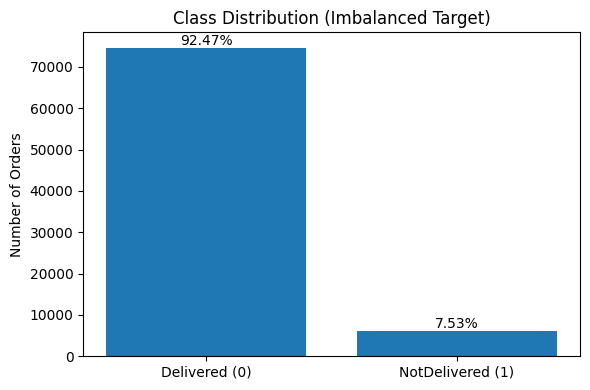

In [10]:
import matplotlib.pyplot as plt

# target như bạn đang dùng
df_model = df[df["OrderStatus"].isin(["Delivered", "Cancelled", "Returned"])].copy()
df_model["NotDelivered"] = df_model["OrderStatus"].isin(["Cancelled", "Returned"]).astype(int)

counts = df_model["NotDelivered"].value_counts().sort_index()
labels = ["Delivered (0)", "NotDelivered (1)"]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts.values)
plt.title("Class Distribution (Imbalanced Target)")
plt.ylabel("Number of Orders")

# hiển thị % trên cột
total = counts.sum()
for i, v in enumerate(counts.values):
    plt.text(i, v, f"{v/total*100:.2f}%", ha="center", va="bottom")

plt.tight_layout()
plt.show()


**Nhận xét mô hình Logistic Regression**

**1 Thiết lập mô hình**
Nhóm xây dựng mô hình Logistic Regression để dự đoán khả năng đơn hàng không hoàn thành (NotDelivered = Cancelled/Returned) dựa trên các đặc trưng đã xử lý và rút ra từ EDA gồm:
Numeric: ShippingCost, Quantity, HighRiskProfile
Categorical (One-hot): PaymentMethod, DiscountGroup, AmountGroup, Customer_type
Dữ liệu được chia 80/20 với stratify=y để giữ tỷ lệ lớp, đồng thời dùng class_weight="balanced" để giảm ảnh hưởng của mất cân bằng lớp.

**2 Kết quả đánh giá**
Trên tập kiểm tra, mô hình đạt:
Accuracy ≈ 76.02%
ROC-AUC ≈ 0.6708
PR-AUC ≈ 0.1432

Với lớp NotDelivered (lớp quan trọng):
Recall ≈ 55.88% (phát hiện được hơn một nửa số đơn rủi ro)
Precision ≈ 16.92% (trong các đơn bị cảnh báo rủi ro, chỉ ~17% là đúng)

Ma trận nhầm lẫn cho thấy:
TP (bắt đúng NotDelivered): 679
FN (bỏ sót NotDelivered): 536
FP (cảnh báo nhầm): 3334

**3 Ý nghĩa (Insight từ kết quả)**
Mô hình có khả năng phân biệt hai lớp ở mức trung bình (ROC-AUC ~0.67 > 0.5), tức là đã học được một số tín hiệu rủi ro từ dữ liệu.
Recall lớp NotDelivered ~56% cho thấy mô hình có thể dùng như một hệ thống cảnh báo sớm, giúp phát hiện đáng kể các đơn hàng có khả năng bị huỷ/trả.
Tuy nhiên, precision thấp (~17%) đồng nghĩa mô hình tạo ra nhiều cảnh báo giả (false positives). Vì vậy, mô hình phù hợp nhất để hỗ trợ kiểm tra bổ sung (xác minh COD, gọi xác nhận, kiểm tra địa chỉ...) thay vì tự động từ chối/huỷ đơn.

**4 Bổ sung đặc trưng HighRiskProfile từ insight EDA**

Từ bước phân tích EDA, nhóm nhận thấy một số tổ hợp giữa giá trị đơn hàng, mức giảm giá và phương thức thanh toán (ví dụ: đơn giá trị cao với giảm giá 20–30% và thanh toán Cash On Delivery, hoặc đơn Medium/High giảm 20–30% qua Amazon Pay) có tỷ lệ huỷ/trả cao hơn rõ rệt so với trung bình.
Do đó, các tổ hợp này được mã hoá thành một biến nhị phân HighRiskProfile (1 nếu đơn thuộc nhóm rủi ro cao, 0 nếu không) để đưa vào mô hình nhằm giúp mô hình “học” trực tiếp pattern rủi ro đã phát hiện.

Kết quả cho thấy HighRiskProfile giúp cải thiện nhẹ các thước đo dựa trên xác suất (ROC-AUC/PR-AUC), nhưng tại ngưỡng mặc định 0.5 thì dự đoán nhãn gần như không thay đổi đáng kể.

**5 Khó khăn và vấn đề gặp phải (Hạn chế)**

(1) Mất cân bằng lớp mạnh
Lớp NotDelivered chiếm tỷ lệ nhỏ, khiến mô hình dễ bị lệch về lớp Delivered. Dù đã dùng class_weight="balanced" để tăng độ nhạy với lớp 1, điều này làm tăng số dự đoán NotDelivered và kéo theo false positive cao.

(2) Trade-off Precision – Recall
Mô hình đạt recall tương đối tốt cho lớp 1, nhưng precision thấp → rất nhiều cảnh báo nhầm. Đây là trade-off phổ biến trong bài toán phát hiện lớp hiếm.

(3) Tính tuyến tính của Logistic Regression
Logistic Regression chỉ mô hình hoá quan hệ tuyến tính theo đặc trưng đã encode. Trong khi đó, rủi ro NotDelivered thường đến từ tương tác phi tuyến giữa nhiều biến (Discount × Amount × PaymentMethod, Customer × Seller, v.v.). Vì vậy mô hình tuyến tính có giới hạn về mức độ cải thiện.

(4) Thông tin còn thiếu để dự đoán tốt hơn
Không có một số biến quan trọng như thời gian giao hàng thực tế, khoảng cách vận chuyển, lịch sử trả hàng chi tiết, hành vi người dùng… nên mô hình khó tăng mạnh độ chính xác với chỉ dữ liệu hiện tại.

**6 Kết luận ngắn**

Mô hình Logistic Regression là một baseline hợp lý, cho khả năng phân biệt ở mức trung bình (ROC-AUC ≈ 0.67) và phát hiện được hơn một nửa đơn rủi ro (Recall ≈ 56%). Tuy nhiên, do dữ liệu mất cân bằng và đặc điểm tương tác phức tạp, mô hình tạo nhiều cảnh báo giả (Precision ≈ 17%). Vì vậy, mô hình phù hợp để làm công cụ cảnh báo hỗ trợ, và nếu triển khai thực tế nên kết hợp với quy trình xác minh/kiểm tra thêm hoặc thử mô hình phi tuyến để cải thiện precision.

In [13]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    balanced_accuracy_score,
)

# 1) Lọc dữ liệu + tạo target
df_model = df[df["OrderStatus"].isin(["Delivered", "Cancelled", "Returned"])].copy()
df_model["NotDelivered"] = (
    df_model["OrderStatus"].isin(["Cancelled", "Returned"]).astype(int)
)

# 2) Chọn features
feature_cols = [
    "TotalAmount",
    "Discount",
    "ShippingCost",
    "Quantity",
    "HighRiskProfile",
    "PaymentMethod",
    "DiscountGroup",
    "AmountGroup",
    "Customer_type",
]

X = df_model[feature_cols].copy()
y = df_model["NotDelivered"].copy()

# 3) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4) Preprocess
num_cols = ["TotalAmount", "Discount", "ShippingCost", "Quantity", "HighRiskProfile"]
cat_cols = ["PaymentMethod", "DiscountGroup", "AmountGroup", "Customer_type"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop",
)

# 5) Random Forest
rf = RandomForestClassifier(
    n_estimators=800,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample",
    max_features="sqrt",
    min_samples_leaf=5,
    min_samples_split=10,
)

model = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("clf", rf),
    ]
)

# 6) Fit
model.fit(X_train, y_train)

# 7) Predict
y_pred_default = model.predict(X_test)  # threshold = 0.5
y_proba = model.predict_proba(X_test)[:, 1]  # xác suất class 1

# 8) AUC metrics (không phụ thuộc threshold)
roc = roc_auc_score(y_test, y_proba)
pr = average_precision_score(y_test, y_proba)

# 9) In kết quả cho 2 threshold
thresholds = [0.50, 0.30]  # bạn có thể đổi 0.30 thành threshold tốt nhất bạn tìm được

for t in thresholds:
    if t == 0.50:
        y_pred = y_pred_default
        mode = "Default threshold (0.50)"
    else:
        y_pred = (y_proba >= t).astype(int)
        mode = f"Custom threshold ({t:.2f})"

    print("\n" + "=" * 80)
    print(mode)
    print("=" * 80)
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("Balanced Accuracy:", round(balanced_accuracy_score(y_test, y_pred), 4))
    print(classification_report(y_test, y_pred, digits=4))
    print(confusion_matrix(y_test, y_pred))

print("\n" + "=" * 80)
print("Threshold-independent metrics (use probabilities)")
print("=" * 80)
print("ROC-AUC:", roc)
print("PR-AUC :", pr)


Default threshold (0.50)
Accuracy: 0.8635
Balanced Accuracy: 0.5591
              precision    recall  f1-score   support

           0     0.9338    0.9174    0.9255     14926
           1     0.1652    0.2008    0.1813      1215

    accuracy                         0.8635     16141
   macro avg     0.5495    0.5591    0.5534     16141
weighted avg     0.8759    0.8635    0.8695     16141

[[13693  1233]
 [  971   244]]

Custom threshold (0.30)
Accuracy: 0.7178
Balanced Accuracy: 0.6259
              precision    recall  f1-score   support

           0     0.9492    0.7341    0.8279     14926
           1     0.1368    0.5177    0.2164      1215

    accuracy                         0.7178     16141
   macro avg     0.5430    0.6259    0.5222     16141
weighted avg     0.8881    0.7178    0.7819     16141

[[10957  3969]
 [  586   629]]

Threshold-independent metrics (use probabilities)
ROC-AUC: 0.6534968946942088
PR-AUC : 0.1307527069820592


In [14]:
# import numpy as np
# import pandas as pd
# import shap

# pre = model.named_steps["preprocess"]
# clf = model.named_steps["clf"]

# # 1) Transform X_test qua preprocess
# X_test_t = pre.transform(X_test)
# feature_names = pre.get_feature_names_out()

# # 2) Sample để chạy nhanh
# n = min(1000, X_test_t.shape[0])
# idx = np.random.RandomState(42).choice(X_test_t.shape[0], size=n, replace=False)
# X_s = X_test_t[idx]

# # 3) Convert sang dense (TreeExplainer hay dễ lỗi với sparse)
# X_s_dense = X_s.toarray() if hasattr(X_s, "toarray") else X_s

# # 4) SHAP
# explainer = shap.TreeExplainer(clf)
# shap_values = explainer.shap_values(
#     X_s_dense, check_additivity=False
# )  # (có thể thêm approximate=True nếu muốn nhanh hơn)

# # 5) Chuẩn hoá sv về dạng (n_samples, n_features) cho class 1 (NotDelivered)
# if isinstance(shap_values, list):
#     sv = shap_values[1]  # class 1
# elif hasattr(shap_values, "values"):  # shap.Explanation
#     sv = shap_values.values
# else:
#     sv = shap_values

# # nếu sv là 3D (n_samples, n_features, n_classes) -> lấy class 1
# if sv.ndim == 3:
#     sv = sv[:, :, 1]

# # kiểm tra chiều dữ liệu phải khớp
# print("X_s_dense shape:", X_s_dense.shape)
# print("sv shape       :", sv.shape)
# print("n feature_names:", len(feature_names))

# assert sv.ndim == 2, f"sv must be 2D, got {sv.shape}"
# assert sv.shape[1] == len(
#     feature_names
# ), f"Mismatch: sv has {sv.shape[1]} features but feature_names has {len(feature_names)}"
# assert X_s_dense.shape[1] == len(
#     feature_names
# ), f"Mismatch: X has {X_s_dense.shape[1]} cols but feature_names has {len(feature_names)}"

# # 6) Tính importance
# mean_abs = np.abs(sv).mean(axis=0)

# imp = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs}).sort_values(
#     "mean_abs_shap", ascending=False
# )

# print(imp.head(20))

# # 7) Plot (bar cho nhanh)
# shap.summary_plot(sv, X_s_dense, feature_names=feature_names, plot_type="bar")